In [4]:
#@title
!pip install fbprophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


###### Importa librerie

In [5]:
#@title
import pandas as pd
from fbprophet import Prophet
from fbprophet.plot import plot_plotly
import plotly.offline as py
import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error
py.init_notebook_mode()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')

## Valori di MAPE e MAE:
##**Annuale =  98.13465440432175; 4016427.403440841**
##**Trimestrale =  86.19454594258488; 831849.8715653862**
##**Mensile = 106.641590758114; 281182.40340572555**
##**Settimanale =  20.03474836238095; 31890.358641560233**

## Annuale Pesca

In [6]:
pesca = pd.read_csv ('calcio_annuale.csv')
pesca = pesca[pesca['year']<2022]
pesca.head(2)

Unnamed: 0  year     revenue
0           0  2014  3365712.79
1           1  2015  4234959.81

**Dividiamo in test e train set** 

In [7]:
steps = 2

pesca_train = pesca.iloc[:(len(pesca)-steps)].rename(columns={'year':'ds', 'revenue': 'y'})
pesca_test = pesca.iloc[(len(pesca)-steps):].rename(columns={'year':'ds', 'revenue': 'y'}) # last year for testing
pesca_test

Unnamed: 0    ds           y
6           6  2020  4764396.03
7           7  2021  3707615.13

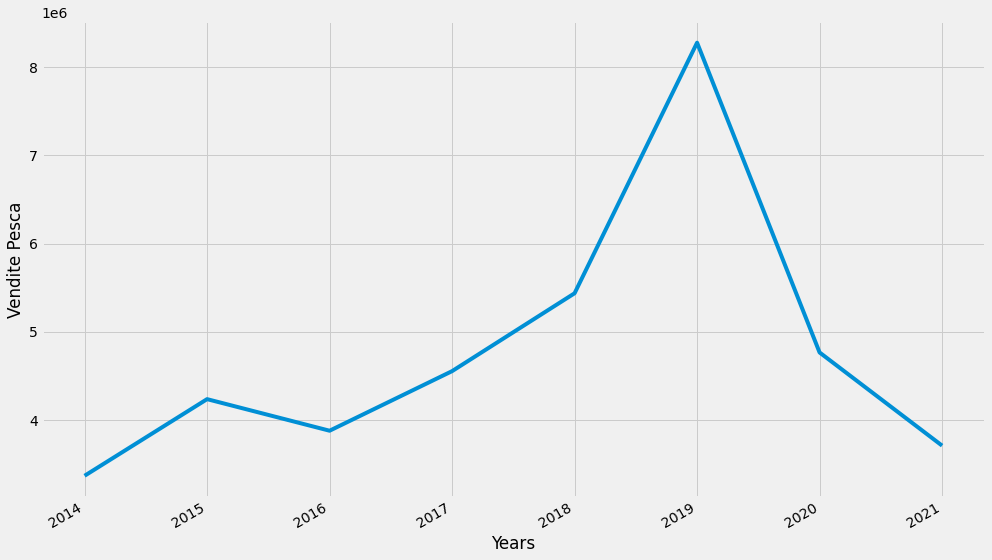

In [8]:
fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(pesca['year'], pesca['revenue'])
ax.set_xlabel('Years')
ax.set_ylabel('Vendite Pesca')

fig.autofmt_xdate()

plt.tight_layout()
plt.show()

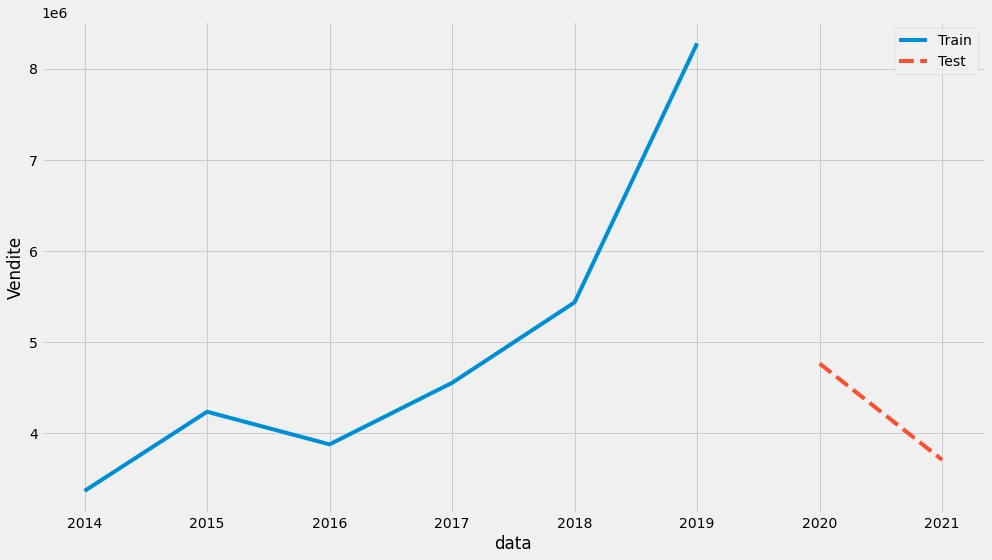

In [9]:
fig, ax = plt.subplots(figsize=(14, 8))

ax.plot(pesca_train['ds'], pesca_train['y'], ls='-', label='Train')
ax.plot(pesca_test['ds'], pesca_test['y'], ls='--', label='Test')
ax.set_xlabel('data')
ax.set_ylabel('Vendite')

ax.legend(loc='best')
plt.tight_layout()
plt.show()

### Prevediamo le vendite

In [10]:
# Impostiamo il livello di confidenza al 95% (the Prophet default is 80%)
my_model = Prophet(interval_width=0.95, n_changepoints=4)

# Fittimao il modello sul train set
my_model.fit(pesca_train)


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 3.


In [11]:
# Prevediamo sul test set
forecasting_model =  my_model.predict(pesca_test)
forecasting_model.head(2)

ds         trend    yhat_lower    yhat_upper   trend_lower  \
0 2020-01-01  2.022996e+06  6.747931e+06  9.603945e+06  2.022996e+06   
1 2021-01-01  2.859180e+06  6.941928e+06  9.704717e+06  2.859180e+06   

    trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0  2.022996e+06    6.149503e+06          6.149503e+06          6.149503e+06   
1  2.859180e+06    5.473187e+06          5.473187e+06          5.473187e+06   

         yearly  yearly_lower  yearly_upper  multiplicative_terms  \
0  6.149503e+06  6.149503e+06  6.149503e+06                   0.0   
1  5.473187e+06  5.473187e+06  5.473187e+06                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper          yhat  
0                         0.0                         0.0  8.172499e+06  
1                         0.0                         0.0  8.332367e+06

In [12]:
y_pred_baseline = pesca_train[-steps:].values
y_pred_baseline

array([[4.00000000e+00, 2.01800000e+03, 5.43588485e+06],
       [5.00000000e+00, 2.01900000e+03, 8.27832197e+06]])

In [13]:
# fig, ax = plt.subplots(figsize=(14, 8))
# ax.plot(pesca_train['ds'], pesca_train['y'], ls='-', label='Train')
# ax.plot(pesca_test['ds'], pesca_test['y'], ls='-', label='Test')
# # ax.plot(y_pred_baseline['ds'], y_pred_baseline['y'], ls=':', label='Baseline')
# ax.plot(forecasting_model['ds'], forecasting_model['yhat'], ls='-.', label='Prophet')

# ax.set_xlabel('data')
# ax.set_ylabel('Vendite')

# ax.legend(loc='best')
# plt.tight_layout()
# plt.show()

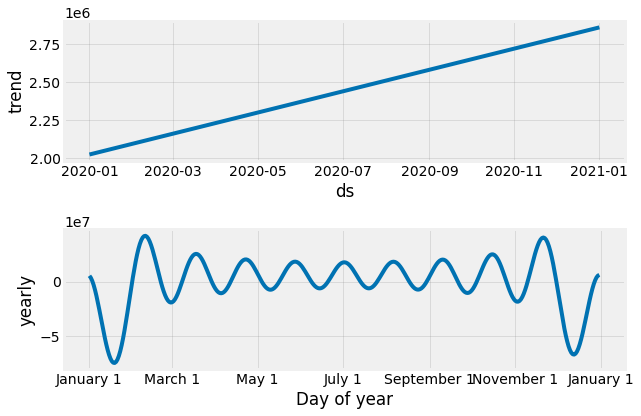

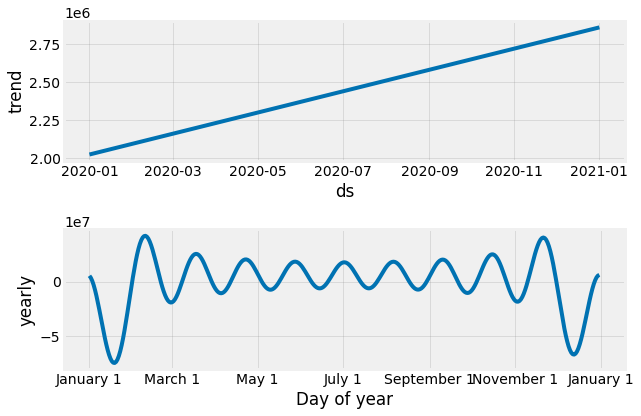

In [14]:
# Componenti del modello (trend, weekly, yearly, daily)
my_model.plot_components(forecasting_model)

**MAPE = 98.13465440432175**
**MAE = 4016427.403440841**

In [15]:
# MAE
def mean_absolute_error(y_true, y_pred):
  """Calculates MAE given y_true and y_pred"""
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs(y_true - y_pred))


# MAPE:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print('MAPE:', mean_absolute_percentage_error(y_true=pesca_test['y'],
                   y_pred=forecasting_model['yhat'])
)
print('MAE:', mean_absolute_error(y_true=pesca_test['y'],
                   y_pred=forecasting_model['yhat']))

MAPE: 98.13465440432175
MAE: 4016427.403440841


##Trimestrale

In [16]:
pesca = pd.read_csv('calcio_trimestrale.csv', parse_dates=['year']) 
pesca = pesca[pesca['year'].dt.year<2022]
pesca.tail(2)

Unnamed: 0       year     revenue
30          30 2021-09-30  1257807.31
31          31 2021-12-31  1350740.40

**Dividiamo in test e train set** 

In [17]:
steps = round(len(pesca)*0.2)

pesca_train = pesca.iloc[:(len(pesca)-steps)].rename(columns={'year':'ds', 'revenue': 'y'})
pesca_test = pesca.iloc[(len(pesca)-steps):].rename(columns={'year':'ds', 'revenue': 'y'}) # last year for testing
pesca_test

Unnamed: 0         ds           y
26          26 2020-09-30  2254753.87
27          27 2020-12-31  1170900.69
28          28 2021-03-31   509403.89
29          29 2021-06-30   589663.53
30          30 2021-09-30  1257807.31
31          31 2021-12-31  1350740.40

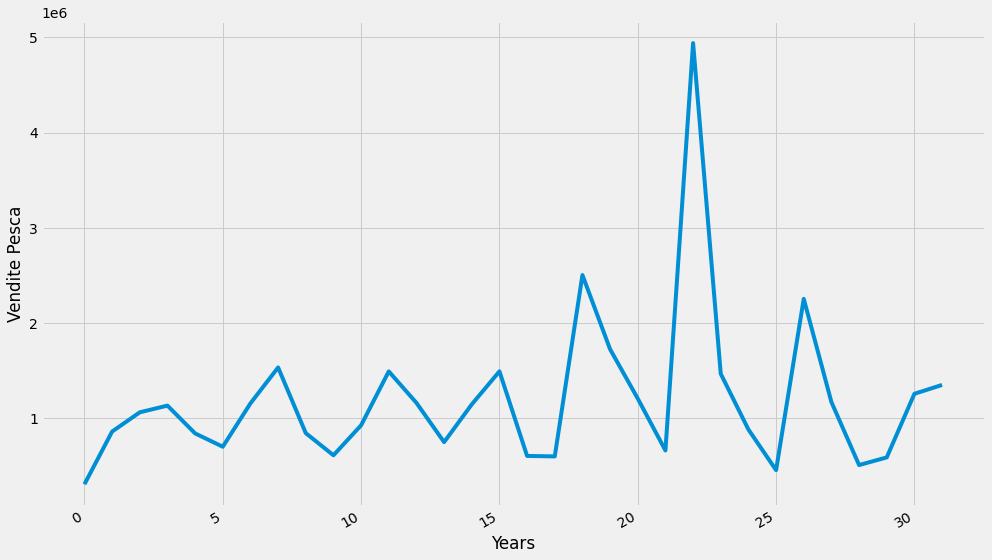

In [18]:
fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(pesca['revenue'])
ax.set_xlabel('Years')
ax.set_ylabel('Vendite Pesca')

fig.autofmt_xdate()

plt.tight_layout()
plt.show()

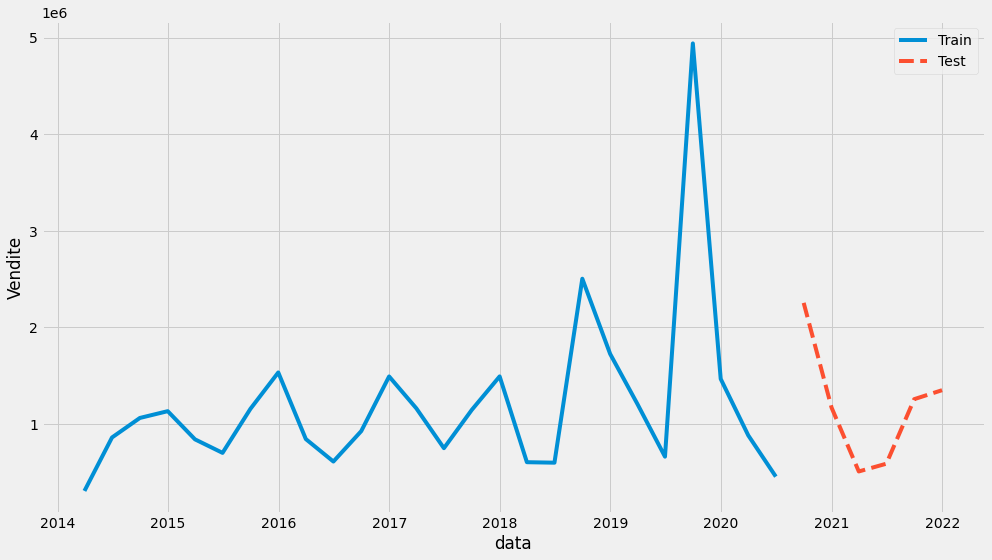

In [19]:
fig, ax = plt.subplots(figsize=(14, 8))

ax.plot(pesca_train['ds'], pesca_train['y'], ls='-', label='Train')
ax.plot(pesca_test['ds'], pesca_test['y'], ls='--', label='Test')
ax.set_xlabel('data')
ax.set_ylabel('Vendite')

ax.legend(loc='best')
plt.tight_layout()
plt.show()

### Prevediamo le vendite

In [20]:
# Impostiamo il livello di confidenza al 95% (the Prophet default is 80%)
my_model = Prophet(interval_width=0.95, n_changepoints=4)

# Fittimao il modello sul train set
my_model.fit(pesca_train)


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [21]:
# Prevediamo sul test set
forecasting_model =  my_model.predict(pesca_test)
forecasting_model.head(2)

ds         trend    yhat_lower    yhat_upper   trend_lower  \
0 2020-09-30  1.586259e+06  2.332363e+05  2.250203e+06  1.586259e+06   
1 2020-12-31  1.623191e+06  1.018319e+06  3.109214e+06  1.623191e+06   

    trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0  1.586259e+06  -394289.228639        -394289.228639        -394289.228639   
1  1.623191e+06   419450.550766         419450.550766         419450.550766   

          yearly   yearly_lower   yearly_upper  multiplicative_terms  \
0 -394289.228639 -394289.228639 -394289.228639                   0.0   
1  419450.550766  419450.550766  419450.550766                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper          yhat  
0                         0.0                         0.0  1.191970e+06  
1                         0.0                         0.0  2.042641e+06

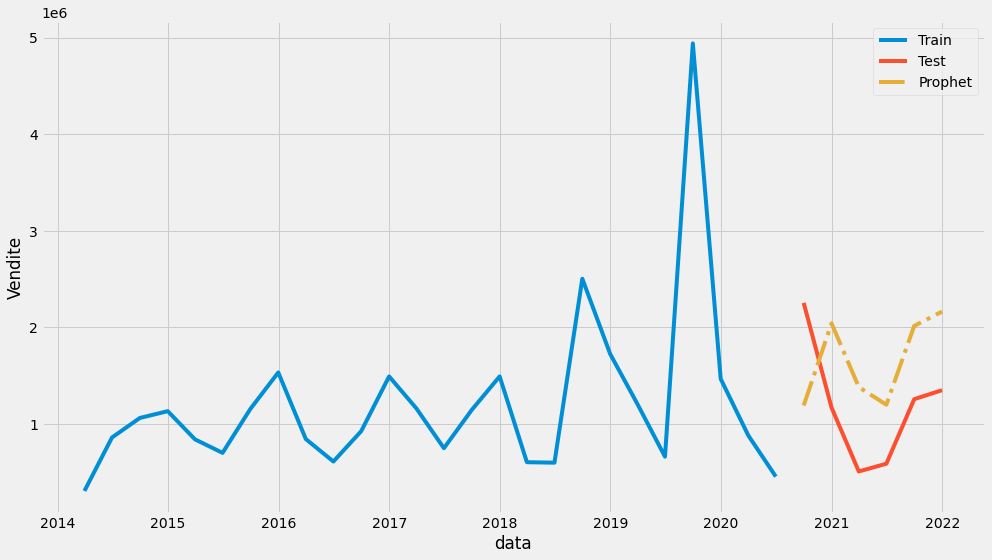

In [22]:
fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(pesca_train['ds'], pesca_train['y'], ls='-', label='Train')
ax.plot(pesca_test['ds'], pesca_test['y'], ls='-', label='Test')
# ax.plot(y_pred_baseline['ds'], y_pred_baseline['y'], ls=':', label='Baseline')
ax.plot(forecasting_model['ds'], forecasting_model['yhat'], ls='-.', label='Prophet')

ax.set_xlabel('data')
ax.set_ylabel('Vendite')

ax.legend(loc='best')
plt.tight_layout()
plt.show()

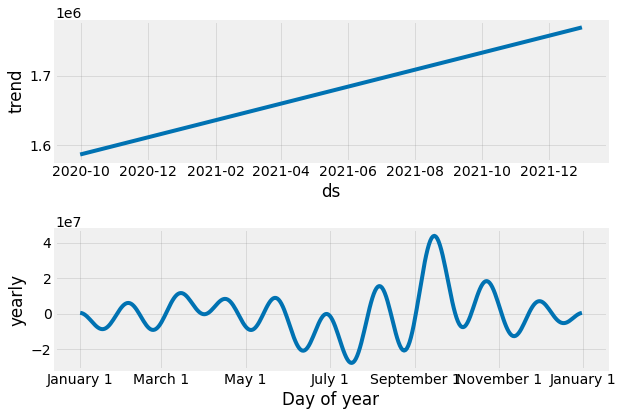

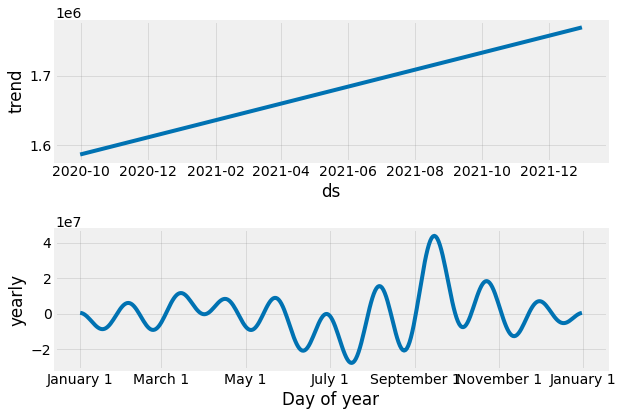

In [23]:
# Componenti del modello (trend, weekly, yearly, daily)
my_model.plot_components(forecasting_model)

**MAPE = 86.19454594258488**
**MAE = 831849.8715653862**

In [24]:
# MAE
def mean_absolute_error(y_true, y_pred):
  """Calculates MAE given y_true and y_pred"""
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs(y_true - y_pred))


# MAPE:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print('MAPE:', mean_absolute_percentage_error(y_true=pesca_test['y'],
                   y_pred=forecasting_model['yhat'])
)
print('MAE:', mean_absolute_error(y_true=pesca_test['y'],
                   y_pred=forecasting_model['yhat']))

MAPE: 86.19454594258488
MAE: 831849.8715653862


##Mensile

In [25]:
pesca = pd.read_csv('calcio_mensile.csv').rename(columns={'Datetime':'year', 'totale':'revenue'})
pesca['year'] = pd.to_datetime(pesca['year']) 
pesca = pesca[pesca['year'].dt.year<2022]
pesca.tail(2)

year    revenue
94 2021-11-30  469943.62
95 2021-12-31  391961.90

**Dividiamo in test e train set** 

In [26]:
steps = round(len(pesca)*0.2)

pesca_train = pesca.iloc[:(len(pesca)-steps)].rename(columns={'year':'ds', 'revenue': 'y'})
pesca_test = pesca.iloc[(len(pesca)-steps):].rename(columns={'year':'ds', 'revenue': 'y'}) # last year for testing
pesca_test

ds           y
77 2020-06-30   126425.81
78 2020-07-31   366231.25
79 2020-08-31   744662.00
80 2020-09-30  1143860.62
81 2020-10-31   581780.80
82 2020-11-30   273004.54
83 2020-12-31   316115.35
84 2021-01-31   220170.52
85 2021-02-28   154246.91
86 2021-03-31   134986.46
87 2021-04-30   218591.82
88 2021-05-31   132760.41
89 2021-06-30   238311.30
90 2021-07-31   391228.62
91 2021-08-31   342640.16
92 2021-09-30   523938.53
93 2021-10-31   488834.88
94 2021-11-30   469943.62
95 2021-12-31   391961.90

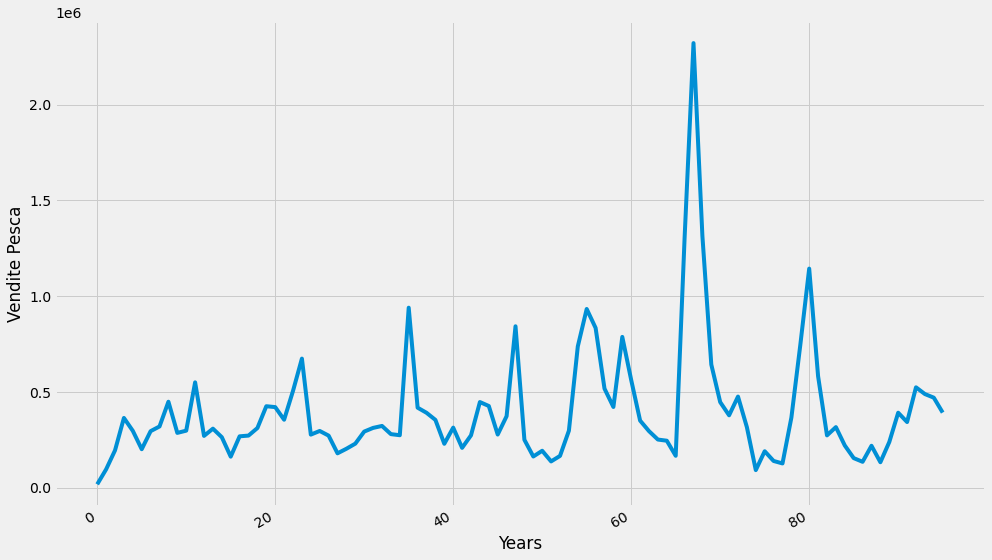

In [27]:
fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(pesca['revenue'])
ax.set_xlabel('Years')
ax.set_ylabel('Vendite Pesca')

fig.autofmt_xdate()

plt.tight_layout()
plt.show()

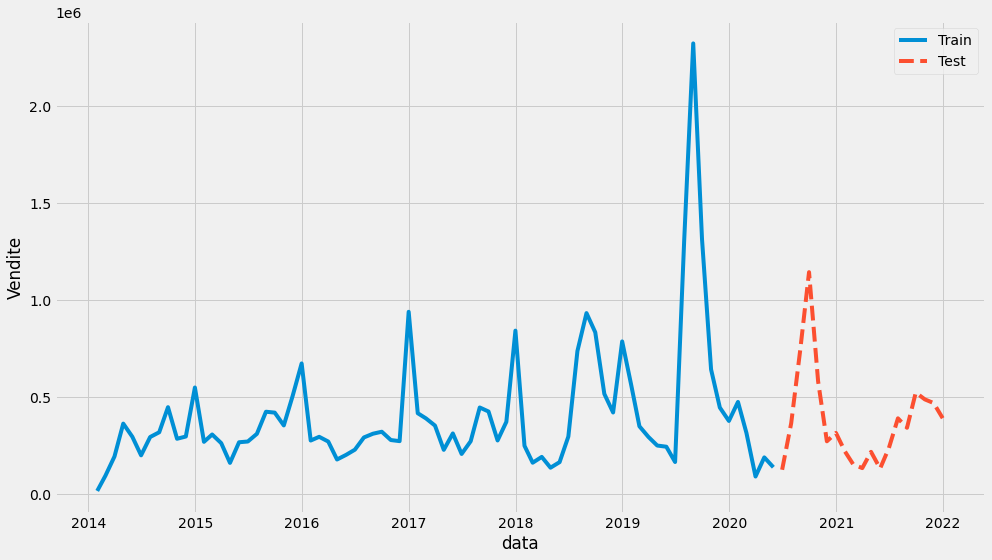

In [28]:
fig, ax = plt.subplots(figsize=(14, 8))

ax.plot(pesca_train['ds'], pesca_train['y'], ls='-', label='Train')
ax.plot(pesca_test['ds'], pesca_test['y'], ls='--', label='Test')
ax.set_xlabel('data')
ax.set_ylabel('Vendite')

ax.legend(loc='best')
plt.tight_layout()
plt.show()

### Prevediamo le vendite

In [29]:
# Impostiamo il livello di confidenza al 95% (the Prophet default is 80%)
my_model = Prophet(interval_width=0.95, n_changepoints=4, weekly_seasonality=True)
my_model.add_seasonality(name='monthly', period=30.5, fourier_order=5)

# Fittimao il modello sul train set
my_model.fit(pesca_train)


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [30]:
# Prevediamo sul test set
forecasting_model =  my_model.predict(pesca_test)
forecasting_model.head(2)

ds          trend     yhat_lower     yhat_upper    trend_lower  \
0 2020-06-30 -668083.212744   30618.990839  845466.789244 -668083.212744   
1 2020-07-31 -678642.145443  137496.982253  991491.357626 -678642.145709   

     trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0 -668083.212744    1.139998e+06          1.139998e+06          1.139998e+06   
1 -678642.145266    1.258512e+06          1.258512e+06          1.258512e+06   

        monthly  ...        weekly  weekly_lower  weekly_upper         yearly  \
0  1.249507e+06  ...   1151.234636   1151.234636   1151.234636 -110660.465056   
1  1.249095e+06  ... -73034.018603 -73034.018603 -73034.018603   82451.088693   

    yearly_lower   yearly_upper  multiplicative_terms  \
0 -110660.465056 -110660.465056                   0.0   
1   82451.088693   82451.088693                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper           yhat  
0                         0.0                         0.0  471914.941348  
1                         0.0                         0.0  579870.341998  

[2 rows x 22 columns]

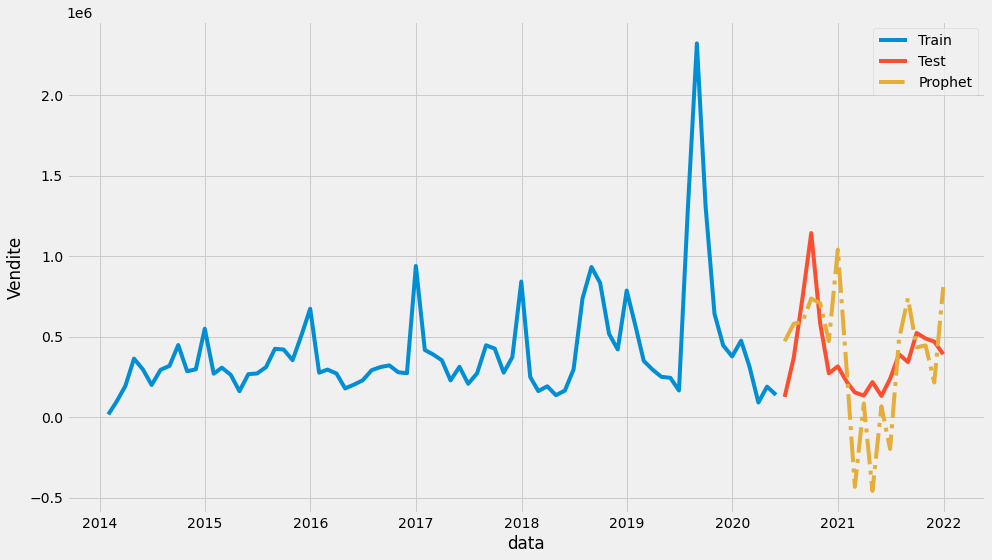

In [31]:
fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(pesca_train['ds'], pesca_train['y'], ls='-', label='Train')
ax.plot(pesca_test['ds'], pesca_test['y'], ls='-', label='Test')
# ax.plot(y_pred_baseline['ds'], y_pred_baseline['y'], ls=':', label='Baseline')
ax.plot(forecasting_model['ds'], forecasting_model['yhat'], ls='-.', label='Prophet')

ax.set_xlabel('data')
ax.set_ylabel('Vendite')

ax.legend(loc='best')
plt.tight_layout()
plt.show()

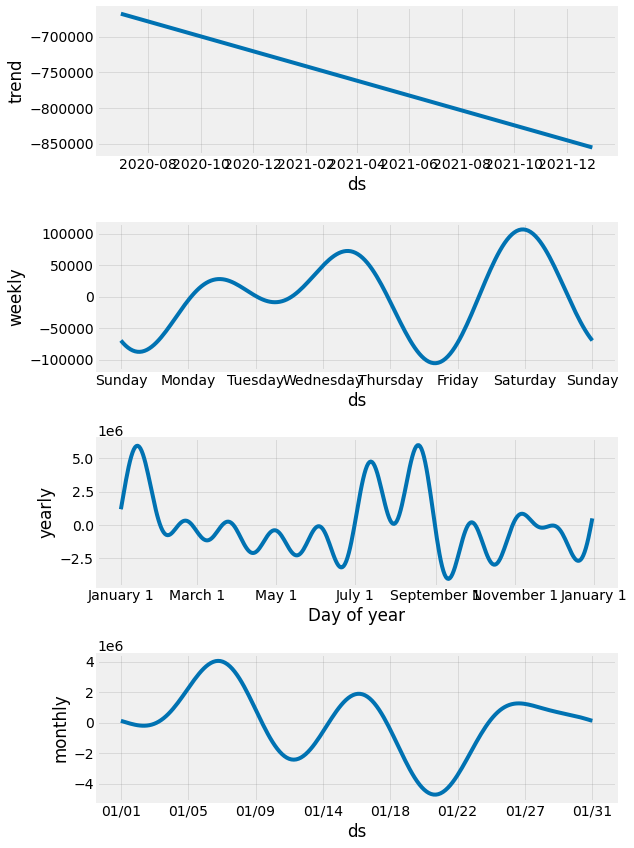

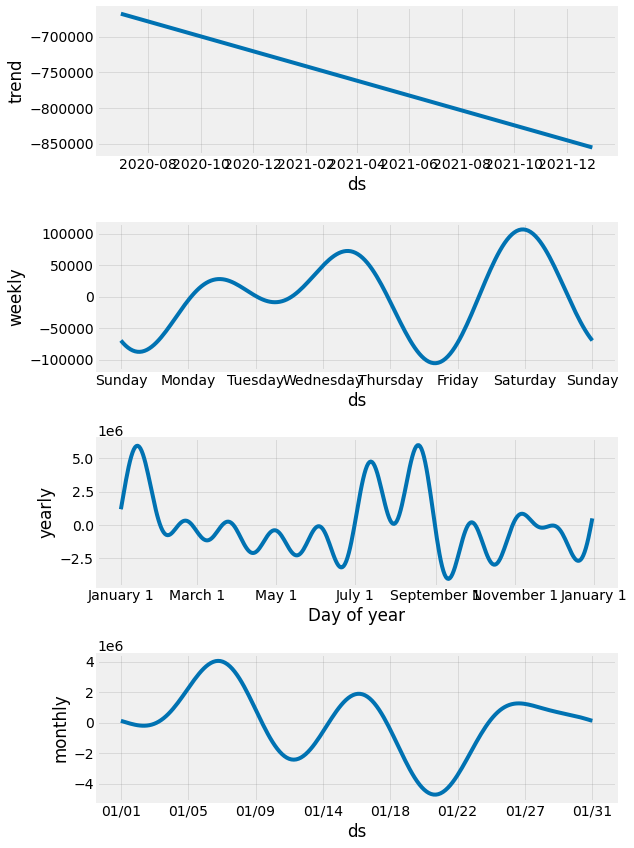

In [32]:
# Componenti del modello (trend, weekly, yearly, daily)
my_model.plot_components(forecasting_model)

**MAPE = 106.641590758114**
**MAE = 281182.40340572555**

In [33]:
# MAE
def mean_absolute_error(y_true, y_pred):
  """Calculates MAE given y_true and y_pred"""
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs(y_true - y_pred))


# MAPE:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print('MAPE:', mean_absolute_percentage_error(y_true=pesca_test['y'],
                   y_pred=forecasting_model['yhat'])
)
print('MAE:', mean_absolute_error(y_true=pesca_test['y'],
                   y_pred=forecasting_model['yhat']))

MAPE: 106.641590758114
MAE: 281182.40340572555


##Settimanale

In [34]:
pesca = pd.read_csv ('calcio_settimanale.csv', parse_dates=['year']) 
pesca = pesca[pesca['year'].dt.year<2022]
pesca.tail(2)

Unnamed: 0       year   revenue
415         415 2021-12-19  98343.61
416         416 2021-12-26  70574.12

**Dividiamo in test e train set** 

In [35]:
steps = round(len(pesca)*0.2)

pesca_train = pesca.iloc[:(len(pesca)-steps)].rename(columns={'year':'ds', 'revenue': 'y'})
pesca_test = pesca.iloc[(len(pesca)-steps):].rename(columns={'year':'ds', 'revenue': 'y'}) # last year for testing
pesca_test

Unnamed: 0         ds          y
334         334 2020-05-31  193686.95
335         335 2020-06-07  188135.90
336         336 2020-06-14  277074.28
337         337 2020-06-21  235418.00
338         338 2020-06-28  149833.56
..          ...        ...        ...
412         412 2021-11-28  237888.83
413         413 2021-12-05  173790.36
414         414 2021-12-12   98639.43
415         415 2021-12-19   98343.61
416         416 2021-12-26   70574.12

[83 rows x 3 columns]

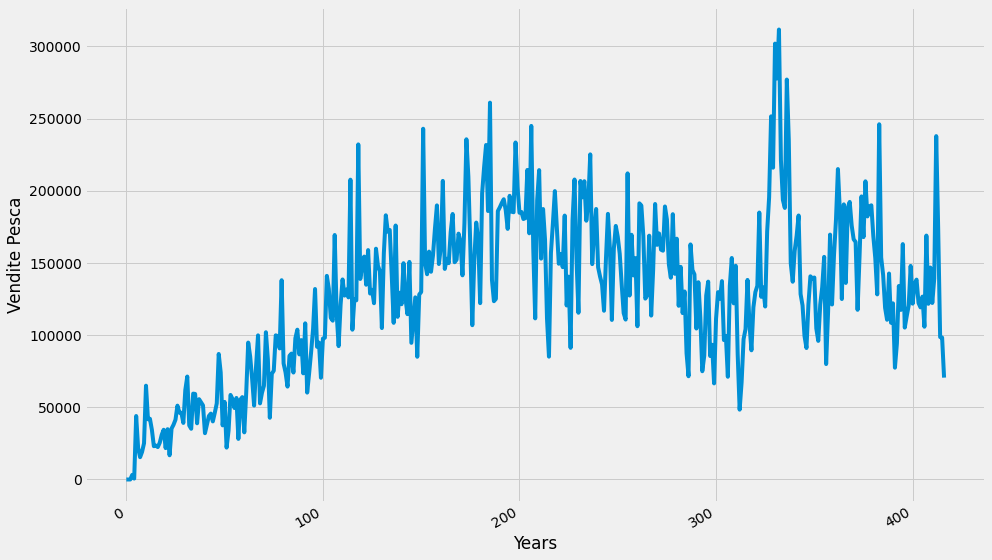

In [36]:
fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(pesca['revenue'])
ax.set_xlabel('Years')
ax.set_ylabel('Vendite Pesca')

fig.autofmt_xdate()

plt.tight_layout()
plt.show()

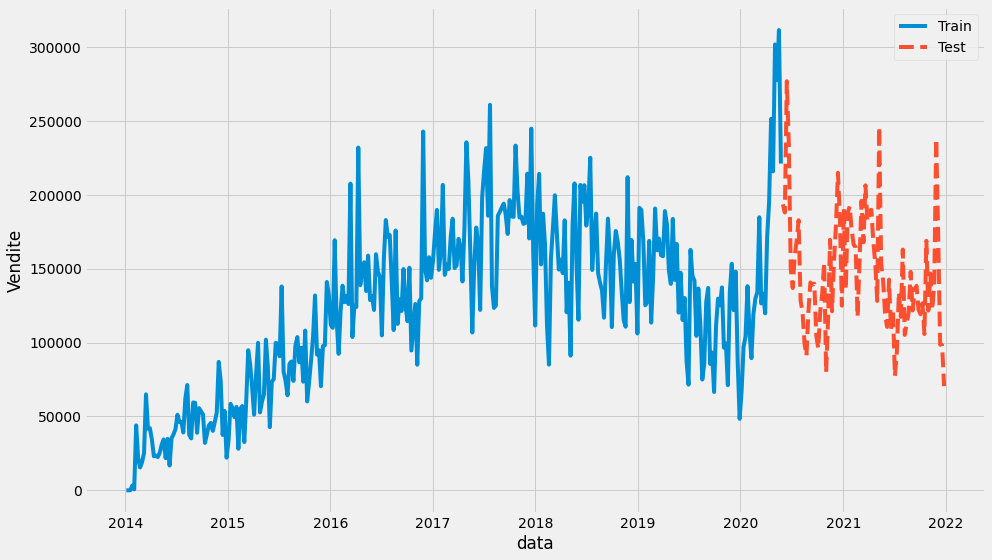

In [37]:
fig, ax = plt.subplots(figsize=(14, 8))

ax.plot(pesca_train['ds'], pesca_train['y'], ls='-', label='Train')
ax.plot(pesca_test['ds'], pesca_test['y'], ls='--', label='Test')
ax.set_xlabel('data')
ax.set_ylabel('Vendite')

ax.legend(loc='best')
plt.tight_layout()
plt.show()

### Prevediamo le vendite

In [38]:
# Impostiamo il livello di confidenza al 95% (the Prophet default is 80%)
my_model = Prophet(interval_width=0.95, n_changepoints=4, daily_seasonality=True)

# Fittimao il modello sul train set
my_model.fit(pesca_train)


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


In [39]:
# Prevediamo sul test set
forecasting_model =  my_model.predict(pesca_test)
forecasting_model.head(2)

ds          trend    yhat_lower     yhat_upper    trend_lower  \
0 2020-05-31  125574.282134  69218.148589  198458.477658  125574.282134   
1 2020-06-07  125311.691733  63791.605682  190408.802819  125311.691733   

     trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0  125574.282134     7413.511429           7413.511429           7413.511429   
1  125311.691733      461.780238            461.780238            461.780238   

          daily   daily_lower   daily_upper       yearly  yearly_lower  \
0  10023.684644  10023.684644  10023.684644 -2610.173215  -2610.173215   
1  10023.684644  10023.684644  10023.684644 -9561.904406  -9561.904406   

   yearly_upper  multiplicative_terms  multiplicative_terms_lower  \
0  -2610.173215                   0.0                         0.0   
1  -9561.904406                   0.0                         0.0   

   multiplicative_terms_upper           yhat  
0                         0.0  132987.793563  
1                         0.0  125773.471971

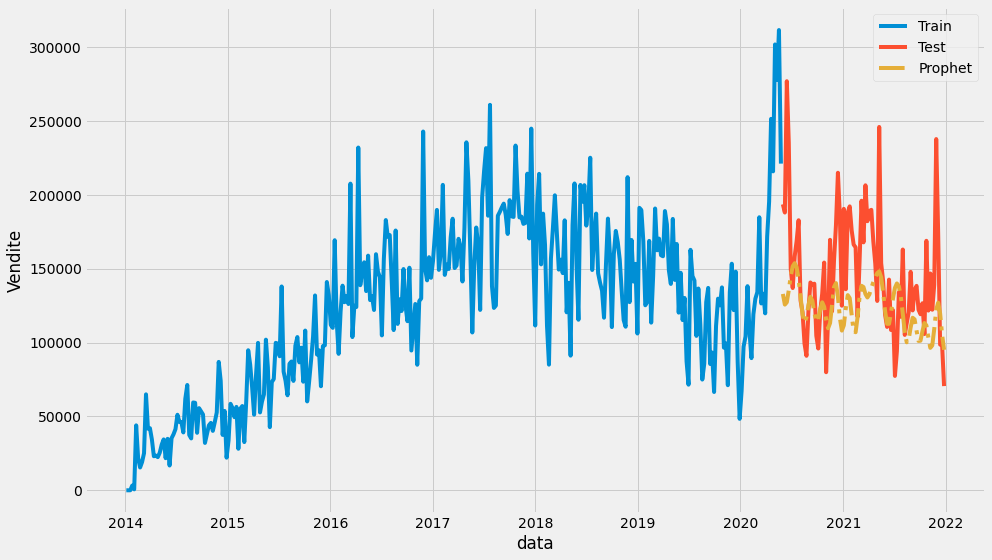

In [40]:
fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(pesca_train['ds'], pesca_train['y'], ls='-', label='Train')
ax.plot(pesca_test['ds'], pesca_test['y'], ls='-', label='Test')
# ax.plot(y_pred_baseline['ds'], y_pred_baseline['y'], ls=':', label='Baseline')
ax.plot(forecasting_model['ds'], forecasting_model['yhat'], ls='-.', label='Prophet')

ax.set_xlabel('data')
ax.set_ylabel('Vendite')

ax.legend(loc='best')
plt.tight_layout()
plt.show()

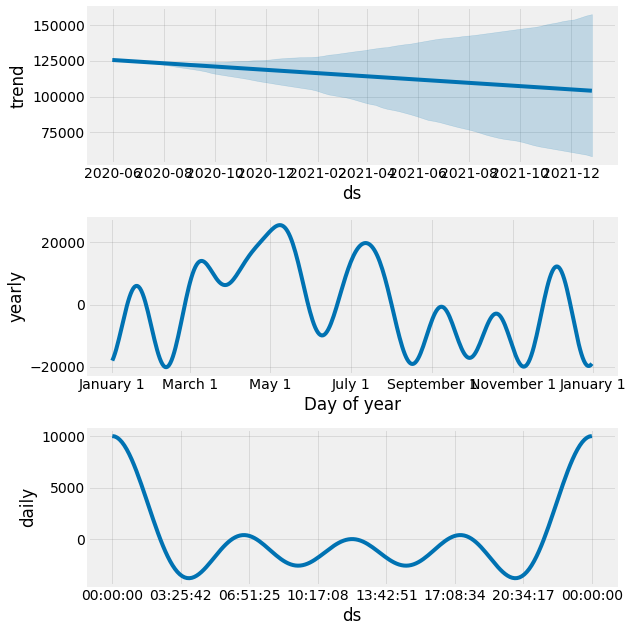

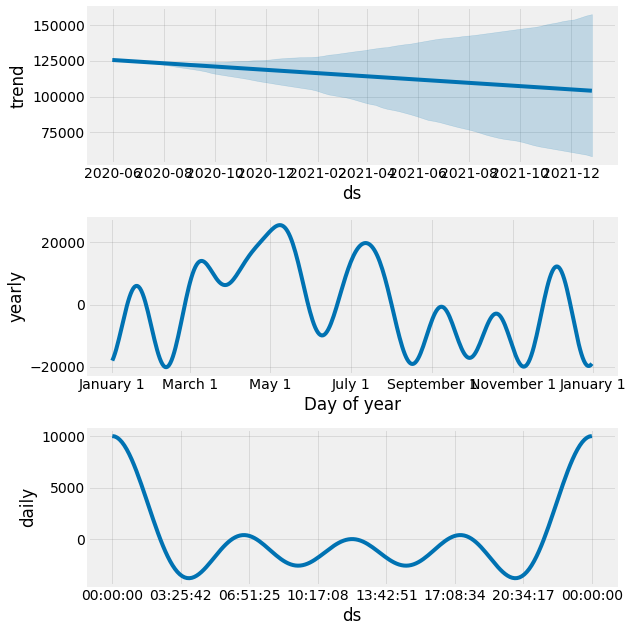

In [41]:
# Componenti del modello (trend, weekly, yearly, daily)
my_model.plot_components(forecasting_model)

**MAPE = 20.03474836238095**
**MAE = 31890.358641560233**

In [42]:
# MAE
def mean_absolute_error(y_true, y_pred):
  """Calculates MAE given y_true and y_pred"""
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs(y_true - y_pred))


# MAPE:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print('MAPE:', mean_absolute_percentage_error(y_true=pesca_test['y'],
                   y_pred=forecasting_model['yhat'])
)
print('MAE:', mean_absolute_error(y_true=pesca_test['y'],
                   y_pred=forecasting_model['yhat']))

MAPE: 20.03474836238095
MAE: 31890.358641560233
